## Setup: Import Libraries and Configure Backend

Import necessary libraries and set up the PyTorch backend for Keras.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Input, SimpleRNN, Dense, Dropout



In [2]:
# Detect operating system and set Keras backend
import os
import platform
import importlib

system = platform.system()
default_backend = "tensorflow" if system == "Darwin" else "torch"

if "KERAS_BACKEND" in os.environ:
    backend = os.environ["KERAS_BACKEND"]
    print(f"Environment override detected: Using {backend.capitalize()} backend")
else:
    backend = default_backend
    print(f"Detected {system}: defaulting to {backend.capitalize()} backend")

module_name = {
    "tensorflow": "tensorflow",
    "torch": "torch",
    "jax": "jax",
}.get(backend, backend)

if importlib.util.find_spec(module_name) is None:
    fallback_backend = "tensorflow"
    if backend != fallback_backend:
        print(f"Warning: Backend {backend!r} requires package {module_name!r}, which is not installed. Falling back to {fallback_backend.capitalize()} backend.")
    backend = fallback_backend

os.environ["KERAS_BACKEND"] = backend
print(f"Final Keras backend: {backend.capitalize()}")



Detected Linux: defaulting to Torch backend
Final Keras backend: Torch


In [3]:
# Check and configure device (GPU/CPU)
def configure_device():
    backend = os.environ.get("KERAS_BACKEND", "tensorflow")

    if backend == "tensorflow":
        import tensorflow as tf
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            print(f"GPU available: {len(gpus)} GPU(s) detected")
            print(f"Using GPU: {gpus[0].name}")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    elif backend == "torch":
        try:
            import torch
        except ImportError:
            print("PyTorch backend requested but torch is not installed. Using CPU.")
            return "CPU"
        if torch.cuda.is_available():
            device = torch.device("cuda")
            print(f"GPU available: {torch.cuda.get_device_name(0)}")
            print("Using GPU")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    else:
        print(f"Unsupported backend {backend!r}. Using CPU by default.")
        return "CPU"

device_type = configure_device()



GPU available: Tesla T4
Using GPU


## Loading / Clean the Dataset




In [49]:
df = pd.read_csv('household_power_consumption.txt', sep=';')

/tmp/ipython-input-4116954226.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('household_power_consumption.txt', sep=';')


In [50]:
display(df.head())

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [51]:
# Convert relevant columns to numeric, coercing errors
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [52]:
#Look at the missing values
df.isnull().sum()

#Fill with the forward fill method
df.fillna(method='ffill', inplace=True)

/tmp/ipython-input-3054071582.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [40]:
df.isnull().sum()

,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [53]:
#Converting to datetime for time series analysis
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                format = "%d/%m/%Y %H:%M:%S")

df.drop(['Date', 'Time'], axis = 1, inplace = True)

#order the values by datetime / make datetime the index
#order the values by datetime
df.sort_values('datetime', inplace=True)

#make datetime the index
df.set_index('datetime', inplace=True)


In [54]:
# Resample to Hourly
#Note the Data spans from 2006-12-16 to 2010-11-26, and is recorded every minute. We want to resample to to every hour.
df_hour = df.resample('h').mean()

print("NaNs per column right after resample:")
print(df_hour.isna().sum())

# Fix them
df_hour = df_hour.ffill().bfill()    # forward fill, then back fill anything left

print("NaNs per column AFTER cleaning:")
print(df_hour.isna().sum())

df_hour.describe().T

NaNs per column right after resample:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
NaNs per column AFTER cleaning:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Global_active_power,34589.0,1.086200,0.894942,0.124000,0.341267,0.799533,1.574967,6.560533
Global_reactive_power,34589.0,0.123326,0.067221,0.000000,0.077667,0.106767,0.149367,0.774333
Voltage,34589.0,240.841505,2.999127,225.834500,239.197167,240.984500,242.691833,251.902000
Global_intensity,34589.0,4.604360,3.746337,0.503333,1.510000,3.406667,6.583333,28.383333
Sub_metering_1,34589.0,1.110951,3.518498,0.000000,0.000000,0.000000,0.000000,48.366667
Sub_metering_2,34589.0,1.287914,4.168720,0.000000,0.000000,0.333333,0.650000,46.433333
Sub_metering_3,34589.0,6.416515,7.344718,0.000000,0.650000,1.650000,14.083333,21.550000


# Train / Validation / Test Split


## Data Preprocessing for Time Series Prediction

**Critical: Preventing Data Leakage**

The correct preprocessing sequence is:

1. **Split first** → Divide dataset into train (70%), validation (15%), and test (15%) sets
2. **Scale with rolling statistics** → Use 100-day rolling mean/std at each time point
3. **Create sliding windows** → Generate sequences for LSTM input


**Scaling Approach:**
- At validation/test time, we use all available historical data (including training data)
- This mimics real-world scenario where you have access to all past data


###  Data Splitting

In [20]:
# 70% train, 15% val, 15% test (time order preserved)
n = len(df_hour)

# compute split indices
train_end = int(0.7 * n)
val_end = int(0.85 * n) # 70% + 15%

# Split without shuffling (important for time series!)
train = df_hour.iloc[:train_end]
val = df_hour.iloc[train_end:val_end]
test = df_hour.iloc[val_end:]

print("Train shape:", train.shape)
print("Val shape:  ", val.shape)
print("Test shape: ", test.shape)

train.head()

Train shape: (12355, 7)
Val shape:   (2647, 7)
Test shape:  (2648, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


## Scaling Features and Target

In [21]:
# Columns
X_cols = ['Global_reactive_power', 'Voltage', 'Global_intensity','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
y_col = 'Global_active_power'

# Scaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# splitting
X_train_raw = train[X_cols]
X_val_raw = val[X_cols]
X_test_raw = test[X_cols]

y_train_raw = train[[y_col]]
y_val_raw = val[[y_col]]
y_test_raw = test[[y_col]]

# fitting and transform
X_train_scaled = scaler_X.fit_transform(X_train_raw) # only fit for trianing
X_val_scaled = scaler_X.transform(X_val_raw)
X_test_scaled = scaler_X.transform(X_test_raw)
y_train_scaled = scaler_Y.fit_transform(y_train_raw)
y_val_scaled = scaler_Y.transform(y_val_raw)
y_test_scaled = scaler_Y.transform(y_test_raw)


In [22]:
# Going back into dfs before sliding windows
# df
X_train_scaled = pd.DataFrame(X_train_scaled, index=train.index, columns=X_cols)
X_val_scaled = pd.DataFrame(X_val_scaled, index=val.index,columns=X_cols)
X_test_scaled = pd.DataFrame(X_test_scaled,index=test.index,columns=X_cols)

print("X_train_scaled shape:",X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train_scaled shape:",y_train_scaled.shape)
print("y_val_scaled shape:", y_val_scaled.shape)
print("y_test_scaled shape:", y_test_scaled.shape)

X_train_scaled shape: (12355, 6)
X_val_scaled shape: (2647, 6)
X_test_scaled shape: (2648, 6)
y_train_scaled shape: (12355, 1)
y_val_scaled shape: (2647, 1)
y_test_scaled shape: (2648, 1)


## Rolling windows for 24-hour lookback

In [23]:
def create_sliding_windows(X_df, y_array, look_back=24, forecast_horizon=1):
    X_windows = []
    y_windows = []

    X_values = X_df.values
    y_values = y_array.reshape(-1)

    for i in range(len(X_df) - look_back - forecast_horizon + 1):
        X_windows.append(X_values[i:i + look_back, :])
        y_windows.append(y_values[i + look_back + forecast_horizon - 1])
    return np.array(X_windows), np.array(y_windows)


look_back = 24 # hours

X_train_seq, y_train_seq = create_sliding_windows(X_train_scaled, y_train_scaled)
X_val_seq, y_val_seq = create_sliding_windows(X_val_scaled, y_val_scaled)
X_test_seq, y_test_seq= create_sliding_windows(X_test_scaled,y_test_scaled)

print("X_train_seq: ",X_train_seq.shape)
print("X_val_seq: ", X_val_seq.shape)
print("X_test_seq: ", X_test_seq.shape)


X_train_seq:  (12331, 24, 6)
X_val_seq:  (2623, 24, 6)
X_test_seq:  (2624, 24, 6)


## 1: Simple RNN Model

### Steps

1. **Define** the RNN model architecture.  
2. **Compile** the model with an appropriate loss function and optimizer.  
3. **Train** the model using an early stopping callback, allowing a large number of epochs without overfitting.  
4. **Visualize** the training process by plotting the learning curves.  
5. **Generate predictions** on the test data.  
6. **Inverse transform** predictions back to the original price scale.  
7. **Evaluate** model performance using RMSE and MAE on the original scale.

### Tips for Improvement
If your model does not achieve a good RMSE consider:
  
- Adding an additional LSTM layer  
- Tuning the learning rate  
- Adjusting the batch size  
- Exploring other regularization or dropout configurations



In [24]:
# baseline rnn model
baseline_rnn = Sequential()
baseline_rnn.add(Input(shape=(look_back, X_train_seq.shape[2])))
baseline_rnn.add(SimpleRNN(64, activation='tanh'))
baseline_rnn.add(Dense(1))

#compiling
baseline_rnn.compile(optimizer='adam', loss='mse')


#looking at baseline
baseline_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
    patience=5,   start_from_epoch=5,restore_best_weights=True)

history_rnn_model = baseline_rnn.fit(
    X_train_seq, y_train_seq,
    epochs=30, batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    shuffle=False,  #for time series
    callbacks=[early_stopping],verbose=1)

print(type(history_rnn_model))
print(history_rnn_model.history.keys())
print("Train loss history length:", len(history_rnn_model.history.get('loss', [])))
print("Val loss history length:", len(history_rnn_model.history.get('val_loss', [])))


Epoch 1/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.6991 - val_loss: 0.2980
Epoch 2/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4516 - val_loss: 0.2626
Epoch 3/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.4075 - val_loss: 0.2562
Epoch 4/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.3899 - val_loss: 0.2595
Epoch 5/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3786 - val_loss: 0.2559
Epoch 6/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3690 - val_loss: 0.2485
Epoch 7/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3638 - val_loss: 0.2434
Epoch 8/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3575 - val_loss: 0.2434
Epoch 9/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3518 - val_loss: 0.2402
Epoch 10/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3463 - val_loss: 0.2459
Epoch 11/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3415 - val_loss: 0.2527
Epoch 12/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/s

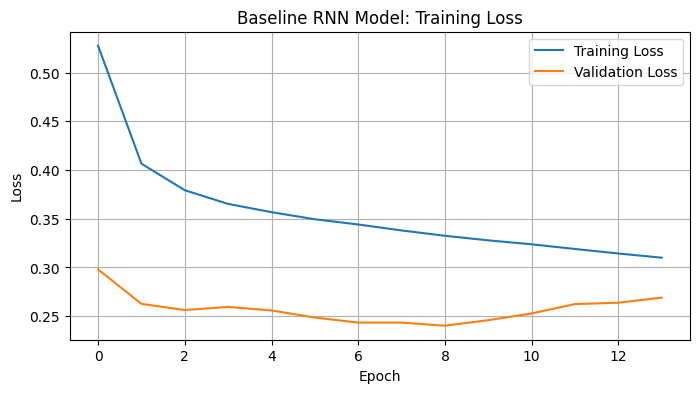

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(history_rnn_model.history['loss'], label='Training Loss')
plt.plot(history_rnn_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Baseline RNN Model: Training Loss')
plt.legend()
plt.grid(True)
plt.show()

The gap between training and validation loss is modest. This implies that the model is not severely overfitting but rather underfitting the more complex temporal patterns in the dataset.

#### Predictions + Performance Evaluation


In [27]:
# predictions
train_pred_rnn = baseline_rnn.predict(X_train_seq)
val_pred_rnn = baseline_rnn.predict(X_val_seq)
test_pred_rnn = baseline_rnn.predict(X_test_seq)

# inverse transforming
train_pred_inv = scaler_Y.inverse_transform(train_pred_rnn)
val_pred_inv= scaler_Y.inverse_transform(val_pred_rnn)
test_pred_inv = scaler_Y.inverse_transform(test_pred_rnn)

train_y_inv = scaler_Y.inverse_transform(y_train_seq.reshape(-1, 1))
val_y_inv = scaler_Y.inverse_transform(y_val_seq.reshape(-1, 1))
test_y_inv = scaler_Y.inverse_transform(y_test_seq.reshape(-1, 1))


386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [28]:
# TEST
test_rmse = np.sqrt(mean_squared_error(test_y_inv, test_pred_inv))
test_mae = mean_absolute_error(test_y_inv, test_pred_inv)

# Train
train_rmse = np.sqrt(mean_squared_error(train_y_inv, train_pred_inv))
train_mae = mean_absolute_error(train_y_inv, train_pred_inv)

print("Test RMSE:", test_rmse, "MAE:", test_mae)
print("Train RMSE:", train_rmse, "MAE:", train_mae)


Test RMSE: 0.6006398703193869 MAE: 0.4276755980548041
Train RMSE: 0.6053322515581104 MAE: 0.43443356899896257


### Visualizing RNN predictions vs. the actual values


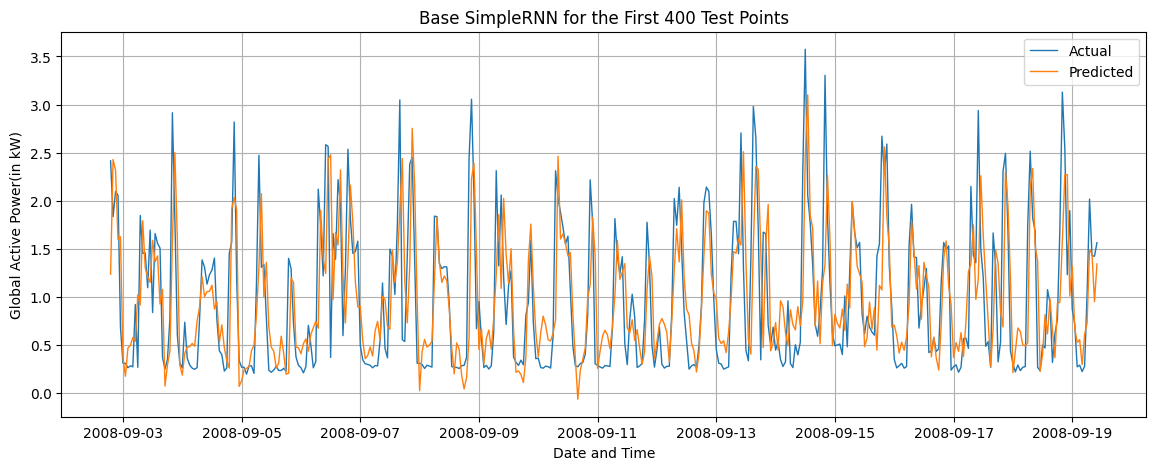

In [29]:
#for the first 400 points
test_index_for_windows = test.index[look_back:]

plt.figure(figsize=(14, 5))
plt.grid(True)
plt.plot(test_index_for_windows[:400], test_y_inv[:400], label='Actual', linewidth=1)
plt.plot(test_index_for_windows[:400], test_pred_inv[:400], label='Predicted', linewidth=1)
plt.xlabel('Date and Time')
plt.ylabel('Global Active Power(in kW)')
plt.title('Base SimpleRNN for the First 400 Test Points')
plt.legend()
plt.show()


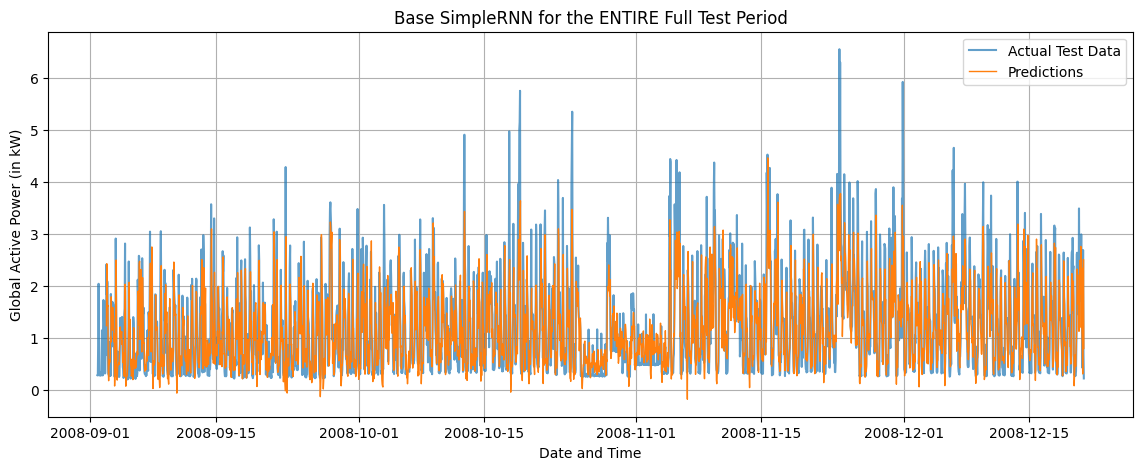

In [30]:
# for the entire test period

plt.figure(figsize=(14, 5))
plt.grid(True)
plt.plot(test.index, test[y_col], label='Actual Test Data', alpha=0.7)
plt.plot(test_index_for_windows, test_pred_inv, label='Predictions', linewidth=1)
plt.xlabel('Date and Time')
plt.ylabel('Global Active Power (in kW)')
plt.title('Base SimpleRNN for the ENTIRE Full Test Period')
plt.legend()
plt.show()


This SimpleRNN model seems to capture the broad daily fluctuations in power usage. But, it performed poorly on many of the sudden spikes + sharp transitions. Over the full test window, it also looks like the model tended underestimate both high-demand peaks and lower points. This makes sense for thus SimpleRNN model, because it might have issues with vanishing gradients + learning long-term dependencies on temperature.


# 2nd RNN Model: More improved

In [31]:
deep_rnn = Sequential()
deep_rnn.add(Input(shape=(look_back, X_train_seq.shape[2])))

#layer 1
deep_rnn.add(SimpleRNN(64, activation='tanh', return_sequences=True))
deep_rnn.add(Dropout(0.3)) # trying dropout rate of 0.3

# layer 2
deep_rnn.add(SimpleRNN(32, activation='tanh'))
deep_rnn.add(Dropout(0.3))

#output
deep_rnn.add(Dense(1))



deep_rnn.compile(optimizer='adam', loss='mse')
deep_rnn.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 24, 64)         │         4,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# training

early_stopping_deep_rnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_deep_rnn = deep_rnn.fit( X_train_seq, y_train_seq,
    epochs=40, batch_size=32,
    validation_data=(X_val_seq, y_val_seq), shuffle=False,
    callbacks=[early_stopping_deep_rnn],verbose=1)

Epoch 1/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 1.1977 - val_loss: 0.2899
Epoch 2/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.5995 - val_loss: 0.2705
Epoch 3/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5218 - val_loss: 0.2587
Epoch 4/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4892 - val_loss: 0.2484
Epoch 5/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.4671 - val_loss: 0.2448
Epoch 6/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.4573 - val_loss: 0.2410
Epoch 7/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.4415 - val_loss: 0.2393
Epoch 8/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.4420 - val_loss: 0.2482
Epoch 9/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.4317 - val_loss: 0.2499
Epoch 10/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.4319 - val_loss: 0.2340
Epoch 11/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4290 - val_loss: 0.2410
Epoch 12/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 1

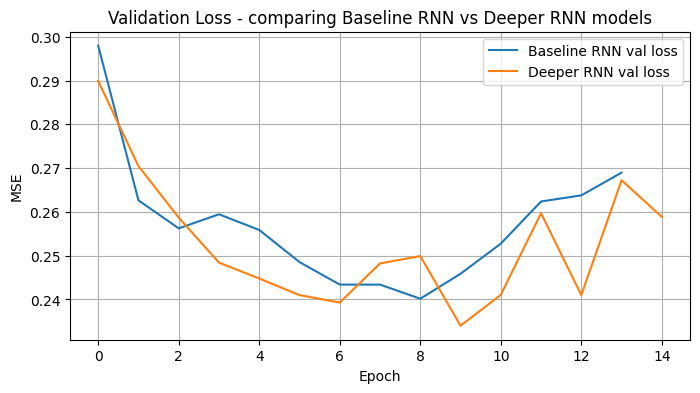

In [33]:
# plotting basline model vs. deep model

plt.figure(figsize=(8, 4))
plt.plot(history_rnn_model.history['val_loss'],label='Baseline RNN val loss')
plt.plot(history_deep_rnn.history['val_loss'], label='Deeper RNN val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation Loss - comparing Baseline RNN vs Deeper RNN models')
plt.legend()
plt.grid(True)
plt.show()

##### Predictions


In [34]:
# predict
train_pred_deep = deep_rnn.predict(X_train_seq)
val_pred_deep = deep_rnn.predict(X_val_seq)
test_pred_deep = deep_rnn.predict(X_test_seq)

# inv transform
train_pred_deep_inv = scaler_Y.inverse_transform(train_pred_deep)
val_pred_deep_inv = scaler_Y.inverse_transform(val_pred_deep)
test_pred_deep_inv= scaler_Y.inverse_transform(test_pred_deep)


# performance
# TEST
test_rmse_deep = np.sqrt(mean_squared_error(test_y_inv, test_pred_deep_inv))
test_mae_deep = mean_absolute_error(test_y_inv, test_pred_deep_inv)

# TRAIN
train_rmse_deep = np.sqrt(mean_squared_error(train_y_inv, train_pred_deep_inv))
train_mae_deep = mean_absolute_error(train_y_inv, train_pred_deep_inv)

# VALIDATION
val_rmse_deep = np.sqrt(mean_squared_error(val_y_inv, val_pred_deep_inv))
val_mae_deep = mean_absolute_error(val_y_inv, val_pred_deep_inv)

print("Test  RMSE:", test_rmse_deep,  "MAE:", test_mae_deep)
print("Train RMSE:", train_rmse_deep, "MAE:", train_mae_deep)

386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test  RMSE: 0.5843143588364546 MAE: 0.41268046426012567
Train RMSE: 0.6175672827801567 MAE: 0.43745493859997264


The deeper RNN led to a slightly lower validation and test error than the baseline model, and the training error was similar/higher. This suggests a bit better of generalization rather than overfitting. However, I'd like to improve it a bit more!


# Tuning the model

I will trying making the model better with the time-based features (hour_cos, dow_sin, etc.) and by tuning the units and dropout.

In [55]:
# Adding calendar features
df_hour['hour'] = df_hour.index.hour
df_hour['dayofweek'] = df_hour.index.dayofweek        # 0 = Monday, 6 = Sunday
df_hour['is_weekend'] = (df_hour['dayofweek'] >= 5).astype(int)

# Cyclical encoding for hour of day (for 24 hours)
df_hour['hour_sin'] = np.sin(2 * np.pi * df_hour['hour'] / 24)
df_hour['hour_cos'] = np.cos(2 * np.pi * df_hour['hour'] / 24)

# Cyclical encoding for day of week (for 7 days)
df_hour['dow_sin'] = np.sin(2 * np.pi * df_hour['dayofweek'] / 7)
df_hour['dow_cos'] = np.cos(2 * np.pi * df_hour['dayofweek'] / 7)

In [56]:
# re-splitting
n = len(df_hour)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

train = df_hour.iloc[:train_end]
val   = df_hour.iloc[train_end:val_end]
test  = df_hour.iloc[val_end:]

In [57]:
# adding new time feaatures to the columns

X_cols = ['Global_reactive_power', 'Voltage', 'Global_intensity','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_weekend']
y_col = 'Global_active_power'

In [46]:

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# raw X and y
X_train_raw = train[X_cols]
X_val_raw = val[X_cols]
X_test_raw = test[X_cols]

y_train_raw = train[[y_col]]
y_val_raw = val[[y_col]]
y_test_raw = test[[y_col]]

# fit and transform
X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_val_scaled = scaler_X.transform(X_val_raw)
X_test_scaled = scaler_X.transform(X_test_raw)
y_train_scaled = scaler_Y.fit_transform(y_train_raw)
y_val_scaled = scaler_Y.transform(y_val_raw)
y_test_scaled = scaler_Y.transform(y_test_raw)

# for df
X_train_scaled = pd.DataFrame(X_train_scaled,index=train.index, columns=X_cols)
X_val_scaled = pd.DataFrame(X_val_scaled, index=val.index, columns=X_cols)
X_test_scaled = pd.DataFrame(X_test_scaled,index=test.index,columns=X_cols)


In [59]:
#slidign windows

look_back = 24

X_train_seq, y_train_seq = create_sliding_windows(X_train_scaled, y_train_scaled)
X_val_seq, y_val_seq = create_sliding_windows(X_val_scaled, y_val_scaled)
X_test_seq, y_test_seq = create_sliding_windows(X_test_scaled,y_test_scaled)

y_train_seq = y_train_seq.reshape(-1, 1)
y_val_seq   = y_val_seq.reshape(-1, 1)
y_test_seq  = y_test_seq.reshape(-1, 1)

# inverse
train_y_inv = scaler_Y.inverse_transform(y_train_seq)
val_y_inv = scaler_Y.inverse_transform(y_val_seq)
test_y_inv = scaler_Y.inverse_transform(y_test_seq)

## Model A: Testing a model with 32 units and dropout = 0.2


In [60]:

units_A = 32
dropout_A = 0.2

deep_rnn_A = Sequential()
deep_rnn_A.add(Input(shape=(look_back, X_train_seq.shape[2])))
deep_rnn_A.add(SimpleRNN(32, activation='tanh', return_sequences=True))
deep_rnn_A.add(Dropout(0.2))
deep_rnn_A.add(SimpleRNN(16, activation='tanh'))
deep_rnn_A.add(Dropout(0.2))
deep_rnn_A.add(Dense(1))

deep_rnn_A.compile(optimizer='adam', loss='mse')

early_stop_A = EarlyStopping(monitor='val_loss', patience=5,
    start_from_epoch=5,restore_best_weights=True)

history_A = deep_rnn_A.fit(X_train_seq, y_train_seq,
    epochs=30,batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    shuffle=False,callbacks=[early_stop_A],
    verbose=1)

# predictions + metrics
train_pred_A = deep_rnn_A.predict(X_train_seq)
val_pred_A = deep_rnn_A.predict(X_val_seq)
test_pred_A= deep_rnn_A.predict(X_test_seq)

train_pred_A_inv = scaler_Y.inverse_transform(train_pred_A)
val_pred_A_inv = scaler_Y.inverse_transform(val_pred_A)
test_pred_A_inv = scaler_Y.inverse_transform(test_pred_A)

train_rmse_A = np.sqrt(mean_squared_error(train_y_inv, train_pred_A_inv))
train_mae_A = mean_absolute_error(train_y_inv, train_pred_A_inv)
test_rmse_A  = np.sqrt(mean_squared_error(test_y_inv,  test_pred_A_inv))
test_mae_A   = mean_absolute_error(test_y_inv,  test_pred_A_inv)

print("Model A (units=32, dropout=0.2)")
print("  Train RMSE:", train_rmse_A, "MAE:", train_mae_A)
print("  Test  RMSE:", test_rmse_A,  "MAE:", test_mae_A)


Epoch 1/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 1.0056 - val_loss: 0.4800
Epoch 2/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.5732 - val_loss: 0.4429
Epoch 3/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.5292 - val_loss: 0.4210
Epoch 4/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.5044 - val_loss: 0.4096
Epoch 5/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4934 - val_loss: 0.3980
Epoch 6/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4783 - val_loss: 0.3954
Epoch 7/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4746 - val_loss: 0.3901
Epoch 8/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4670 - val_loss: 0.3865
Epoch 9/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4643 - val_loss: 0.3770
Epoch 10/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4607 - val_loss: 0.3787
Epoch 11/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.4544 - val_loss: 0.3702
Epoch 12/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 8s 10

## Model B: Testing a model with 64 units and dropout = 0.4


In [62]:
units_B = 64
dropout_B = 0.4

deep_rnn_B = Sequential()
deep_rnn_B.add(Input(shape=(look_back, X_train_seq.shape[2])))
deep_rnn_B.add(SimpleRNN(64, activation='tanh', return_sequences=True))
deep_rnn_B.add(Dropout(0.4))
deep_rnn_B.add(SimpleRNN(32, activation='tanh'))
deep_rnn_B.add(Dropout(0.4))
deep_rnn_B.add(Dense(1))

deep_rnn_B.compile(optimizer='adam', loss='mse')

early_stop_B = EarlyStopping(monitor='val_loss',
    patience=5,start_from_epoch=5,
    restore_best_weights=True)

history_B = deep_rnn_B.fit(X_train_seq, y_train_seq,
    epochs=30, batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    shuffle=False, callbacks=[early_stop_B], verbose=1)

# predictions + metrics
train_pred_B = deep_rnn_B.predict(X_train_seq)
val_pred_B = deep_rnn_B.predict(X_val_seq)
test_pred_B = deep_rnn_B.predict(X_test_seq)

train_pred_B_inv = scaler_Y.inverse_transform(train_pred_B)
val_pred_B_inv = scaler_Y.inverse_transform(val_pred_B)
test_pred_B_inv= scaler_Y.inverse_transform(test_pred_B)

train_rmse_B = np.sqrt(mean_squared_error(train_y_inv, train_pred_B_inv))
train_mae_B = mean_absolute_error(train_y_inv, train_pred_B_inv)
test_rmse_B = np.sqrt(mean_squared_error(test_y_inv,test_pred_B_inv))
test_mae_B = mean_absolute_error(test_y_inv,test_pred_B_inv)

print("Train RMSE:", train_rmse_B, "MAE:", train_mae_B)
print("Test  RMSE:", test_rmse_B,  "MAE:", test_mae_B)


Epoch 1/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 1.2088 - val_loss: 0.5095
Epoch 2/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.6373 - val_loss: 0.4591
Epoch 3/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5543 - val_loss: 0.4469
Epoch 4/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.5276 - val_loss: 0.4382
Epoch 5/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.5147 - val_loss: 0.4449
Epoch 6/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.5056 - val_loss: 0.4474
Epoch 7/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.4913 - val_loss: 0.4215
Epoch 8/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.4810 - val_loss: 0.4096
Epoch 9/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.4750 - val_loss: 0.4086
Epoch 10/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4656 - val_loss: 0.3991
Epoch 11/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.4634 - val_loss: 0.4028
Epoch 12/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 1

## Model C - adding a layers

In [63]:

units_C = 64
dropout_C = 0.3

deep_rnn_C = Sequential()
deep_rnn_C.add(Input(shape=(look_back, X_train_seq.shape[2])))

# layer 1
deep_rnn_C.add(SimpleRNN( 64, activation='tanh', return_sequences=True))
deep_rnn_C.add(Dropout(0.3))

# layer 2
deep_rnn_C.add(SimpleRNN( 64, activation='tanh', return_sequences=True))
deep_rnn_C.add(Dropout(0.3))

# layer 3
deep_rnn_C.add(SimpleRNN( 64 // 2, activation='tanh'))
deep_rnn_C.add(Dropout(0.3))

# output
deep_rnn_C.add(Dense(1))




deep_rnn_C.compile(optimizer='adam', loss='mse')
deep_rnn_C.summary()

early_stop_C = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=5, restore_best_weights=True)

history_C = deep_rnn_C.fit( X_train_seq, y_train_seq,
    epochs=30, batch_size=32, validation_data=(X_val_seq, y_val_seq),
    shuffle=False, callbacks=[early_stop_C], verbose=1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, 24, 64)         │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 24, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,257 (63.50 KB)

 Trainable params: 16,257 (63.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 33s 32ms/step - loss: 1.0846 - val_loss: 0.4927
Epoch 2/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.6276 - val_loss: 0.4808
Epoch 3/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.5603 - val_loss: 0.4575
Epoch 4/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.5308 - val_loss: 0.4439
Epoch 5/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.5099 - val_loss: 0.4460
Epoch 6/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.4938 - val_loss: 0.4288
Epoch 7/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4832 - val_loss: 0.4309
Epoch 8/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.4731 - val_loss: 0.4101
Epoch 9/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4634 - val_loss: 0.4010
Epoch 10/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.4589 - val_loss: 0.4078
Epoch 11/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4545 - val_loss: 0.3866
Epoch 12/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8

In [64]:
# Predictions
train_pred_C = deep_rnn_C.predict(X_train_seq)
val_pred_C = deep_rnn_C.predict(X_val_seq)
test_pred_C= deep_rnn_C.predict(X_test_seq)

train_pred_C_inv = scaler_Y.inverse_transform(train_pred_C)
val_pred_C_inv= scaler_Y.inverse_transform(val_pred_C)
test_pred_C_inv = scaler_Y.inverse_transform(test_pred_C)

train_rmse_C = np.sqrt(mean_squared_error(train_y_inv, train_pred_C_inv))
train_mae_C = mean_absolute_error(train_y_inv,train_pred_C_inv)

val_rmse_C = np.sqrt(mean_squared_error(val_y_inv,val_pred_C_inv))
val_mae_C= mean_absolute_error(val_y_inv,val_pred_C_inv)

test_rmse_C= np.sqrt(mean_squared_error(test_y_inv, test_pred_C_inv))
test_mae_C= mean_absolute_error(test_y_inv,test_pred_C_inv)

print("Train RMSE:", train_rmse_C, "MAE:", train_mae_C)
print("Test RMSE:", test_rmse_C,"MAE:", test_mae_C)


756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Train RMSE: 0.5727806858086217 MAE: 0.39638265167181735
Test  RMSE: 0.47358025494933004 MAE: 0.3395743551838479


Note: The RMSE values are in units of kilowatts, so a test RMSE of 0.47 kW is actually an improvement over 0.57 or 0.60 kW. The numbers  looked misleading at first, but lower RMSE always indicates better performance.

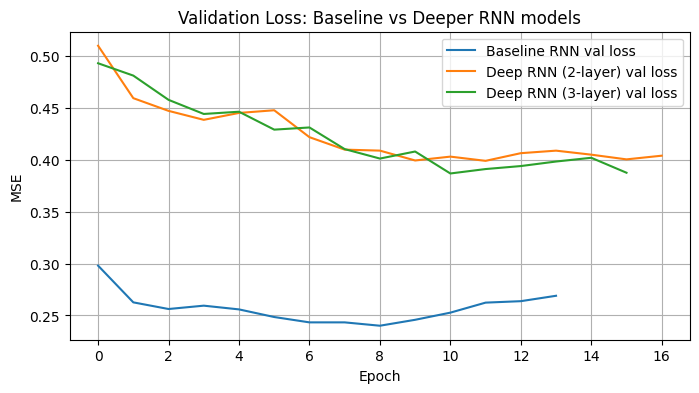

In [66]:
plt.figure(figsize=(8,4))
plt.plot(history_rnn_model.history['val_loss'], label='Baseline RNN val loss')
plt.plot(history_B.history['val_loss'],   label='Deep RNN (2-layer) val loss')
plt.plot(history_C.history['val_loss'],   label='Deep RNN (3-layer) val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation Loss: Baseline vs Deeper RNN models')
plt.legend()
plt.grid(True)
plt.show()


Looking at the validation-loss plot, the deeper RNN models clearly benefit from having more layers. The 2-layer model improves over time, but the 3-layer version consistently ends up a bit lower, which suggests it’s doing a better job capturing the patterns in the electricity data. The baseline curve sits on a different scale since it was trained without the extra time-based features, so it isn’t directly comparable. What’s encouraging is that the deeper models don’t show obvious overfitting (the validation loss stays close to the training loss) so the extra depth actually seems to help rather than hurt. This matches what we saw in the test results (where the 3-layer RNN performed well overall)


So although the validation-loss curves for the deeper RNNs appear higher than the baseline RNN, the values are not directly comparable because the baseline model was trained on a different feature set and scaling pipeline.

When we evaluate all models on the same test set in the original kW units, the deeper 3-layer RNN performs the best, because it reduces the test RMSE from about 0.60 kW (from the baseline) to about 0.47 kW. So, the deeper architecture generalizes better, even though its raw validation-loss scale looks higher.

In [67]:
# for turning into an HTML

import json
from pathlib import Path
from google.colab import files, _message

# 1) Get the current Colab notebook as a Python dict
nb = _message.blocking_request("get_ipynb")["ipynb"]

# 2) Strip problematic widgets metadata (which causes the 'state' KeyError)
nb.setdefault("metadata", {})
nb["metadata"].pop("widgets", None)

# 3) Save cleaned notebook to disk
ipynb_path = "/content/HW2_rnn_ts_template.ipynb"
Path(ipynb_path).write_text(json.dumps(nb), encoding="utf-8")

# 4) Convert to HTML with all code visible (no --no-input flag)
!jupyter nbconvert --to html "$ipynb_path" --output "HW2_rnn_ts_template" --output-dir="/content"

# 5) Download the HTML file
files.download("/content/HW2_rnn_ts_template.html")

[NbConvertApp] Converting notebook /content/HW2_rnn_ts_template.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 1087532 bytes to /content/HW2_rnn_ts_template.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>